In [4]:
%matplotlib inline

from deepsea import *
from keras.models import load_model

from IntegratedGradients import integrated_gradients

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
dsmodel = load_model("models/deepsea/weights-improvement-09-0.06-full.hdf5")

In [6]:
dsmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
valid_X, valid_Y, train_X, train_Y, test_X, test_Y = loaddata()

# Using Ingetraged Gradients

In [10]:
ig = integrated_gradients(dsmodel, [0])

Evaluated output channels (0-based index): 0
Building gradient functions
Progress: 100.0%
Done.


In [11]:
prediction = dsmodel.predict(valid_X)

In [13]:
indexes = [i for i in range(len(valid_Y[:,0])) if valid_Y[:,0][i] == 1 and prediction[:, 0][i] > 0.6]

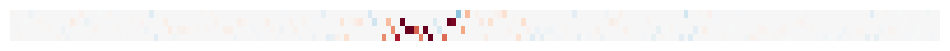

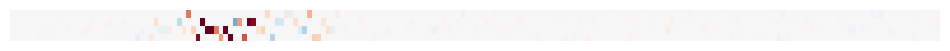

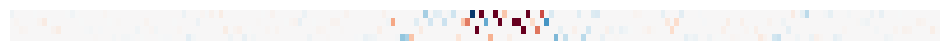

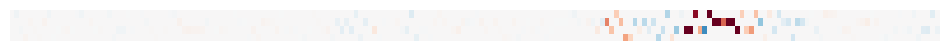

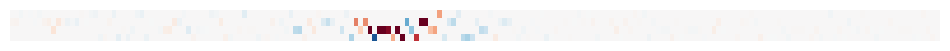

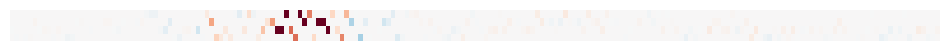

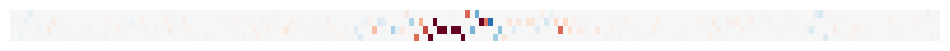

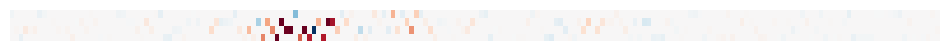

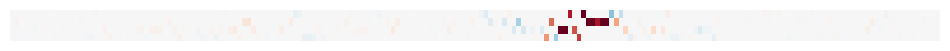

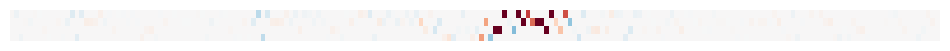

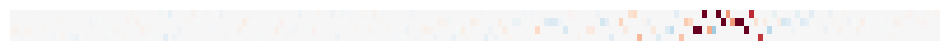

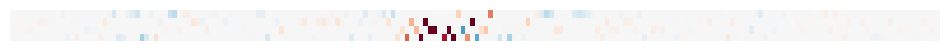

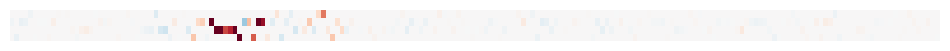

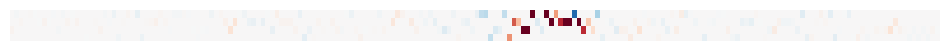

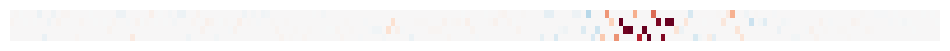

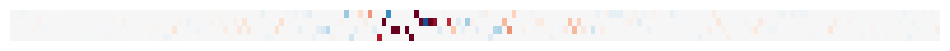

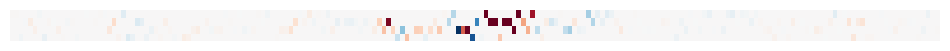

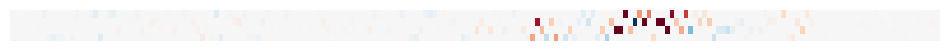

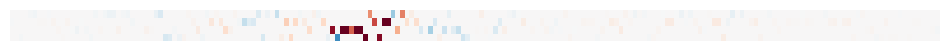

In [16]:
for index in indexes:
    ex = ig.explain(valid_X[index])
    plt.figure(figsize=(12,0.4))
    sns.heatmap(np.transpose(ex[0,400:600]), cbar=False, vmin=-0.05, vmax=0.05)
    plt.yticks([],[])
    plt.xticks([],[])
    plt.show()